In [ ]:
!pip install pgeocode
!pip install pingouin
!conda install -c pyviz hvplot


In [2]:
import os


os.environ["DASK_TEMPORARY_DIRECTORY"] = "tmp/dask"
os.environ["PGEOCODE_DATA_DIR"] = "tmp/pgeocode_data"
if not os.path.exists("tmp"):
    os.mkdir("tmp")
if not os.path.exists("tmp/dask"):
    os.mkdir("tmp/dask")
if not os.path.exists("tmp/pgeocode_data"):
    os.mkdir("tmp/pgeocode_data")
import pandas as pd
import hvplot.pandas
import dask
import hvplot.dask
import dask.dataframe as dd
import json
import tqdm
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
import pgeocode as geo
import panel as pn
pn.extension(comms="vscode")


In [2]:
!ls data_dpg_testdata/reduced/ 

mapping_article_files.json
mapping_city.json
mapping_geo.json
mapping_refferer.json
mapping_view_files.json
reduced_articles_df_article.csv
reduced_articles_df_external_categories.csv
reduced_articles_df_external_entities.csv
reduced_articles_df_external_topics.csv
reduced_articles_df_fixed_set_sensitive.csv
reduced_articles_df_fixed_set_topics.csv
reduced_articles_df_fixed_set_userneeds.csv
reduced_articles_df_internal_topics.csv
reduced_interactions.csv
reduced_views.csv


In [3]:
DATA_FOLDER = "preflight"

In [4]:
ddf_views = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER}/reduced_views.csv', dtype={'GEO_ZIPCODE': object,
       'REFR_MEDIUM': object, 'IS_LOGGED_IN': object, 'file_name': object,
"privacy_advertising":int,       
"privacy_analytics":int,       
"privacy_functional":int,       
"privacy_geo_location":int,       
"privacy_marketing":int,       
"privacy_non-personalised_ads":int,       
"privacy_personalisation":int,       
"privacy_social_media":int,       
"privacy_target_advertising":int,       
       
       })
ddf_views["article_id"] = ddf_views["ARTICLE_ID"]
ddf_views = ddf_views.drop(["ARTICLE_ID"] , axis=1)
ddf_views["DERIVED_TSTAMP"] = dd.to_datetime(ddf_views["DERIVED_TSTAMP"])
ddf_views["hour"] = ddf_views["DERIVED_TSTAMP"].dt.hour
ddf_views["weekday"] = ddf_views["DERIVED_TSTAMP"].dt.weekday
ddf_views["dayofmonth"] = ddf_views["DERIVED_TSTAMP"].dt.day
ddf_views["month"] = ddf_views["DERIVED_TSTAMP"].dt.month
ddf_views = ddf_views.replace("nu.web.advertorial", "nu.web")
ddf_views_unidentified = ddf_views[ddf_views["QUASI_USER_ID"].isna()].copy()
ddf_views = ddf_views[~ddf_views["QUASI_USER_ID"].isna()]
device_counts = ddf_views["APP_ID"].value_counts().compute()
# sample_amount = (device_counts.min()//100000)*100000
sample_amount = device_counts.min()
# sample_amount = 1000000
unique_devices = device_counts.index.unique()
columns_privacy = list(ddf_views.columns[ddf_views.columns.str.startswith("privacy_")].values)
columns_time = ["hour", "weekday", "dayofmonth", "month"]

In [5]:
ddf_views = ddf_views.groupby('APP_ID').apply(lambda df: df.sample(sample_amount if len(df) else 0) , meta=ddf_views.partitions[0]).reset_index(drop=True)
ddf_views = ddf_views.set_index('article_id')
ddf_views

Dask DataFrame Structure:
                APP_ID  DERIVED_TSTAMP GEO_CITY GEO_COUNTRY GEO_REGION GEO_ZIPCODE REFR_MEDIUM REFR_URLHOST QUASI_USER_ID IS_LOGGED_IN privacy_functional privacy_analytics privacy_target_advertising privacy_personalisation privacy_non-personalised_ads privacy_marketing privacy_social_media privacy_geo_location privacy_advertising file_name   hour weekday dayofmonth  month
npartitions=33                                                                                                                                                                                                                                                                                                                                                                        
6               object  datetime64[ns]    int64      object     object      object      object        int64        object       object              int64             int64                      int64                   int64                        int64             int64                int64                int64               int64    object  int64   int64      int64  int64
6910               ...             ...      ...         ...        ...         ...         ...          ...           ...          ...                ...               ...                        ...                     ...                          ...               ...                  ...                  ...                 ...       ...    ...     ...        ...    ...
...                ...             ...      ...         ...        ...         ...         ...          ...           ...          ...                ...               ...                        ...                     ...                          ...               ...                  ...                  ...                 ...       ...    ...     ...        ...    ...
6225575            ...             ...      ...         ...        ...         ...         ...          ...           ...          ...                ...               ...                        ...                     ...                          ...               ...                  ...                  ...                 ...       ...    ...     ...        ...    ...
20039600           ...             ...      ...         ...        ...         ...         ...          ...           ...          ...                ...               ...                        ...                     ...                          ...               ...                  ...                  ...                 ...       ...    ...     ...        ...    ...
Dask Name: sort_index, 1291 tasks

In [6]:
DATA_FOLDER_ARTICLES = "reduced"
ddf2 = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_article.csv', dtype={'sub_section': 'object',
       'url': 'object'})
ddf2 = ddf2.set_index('article_id')
ddf2.head()

cds_content_id brands  \
article_id                                               
537071      article-mm-6229c19da07c8a000163379b  nu.nl   
962788      article-mm-621539e134c4a7000191db08  nu.nl   
1013291     article-mm-6239e222e28ee500012c67ff  nu.nl   
1149251     article-mm-6229c559c1fdac00016a6b3e  nu.nl   
1401797     article-mm-626a799867ff2a00019c059e  nu.nl   

                                               title  \
article_id                                             
537071       Peugeot 307 in alle opzichten verbeterd   
962788         Hier is hij dan: de nieuwe Volvo V70!   
1013291                           De Peugeot 207 SW!   
1149251               Meer details nieuwe Opel Agila   
1401797     Oranje meest populair voor Dodge Charger   

                                                         text      authors  \
article_id                                                                   
537071      Het nieuwe gezicht komt op alle carrosserievar...          ANP   
962788      De voorzijde van de Volvo V70 krijgt trekken v...  autoweek.nl   
1013291     In de Peugeot-vestiging in Poissy is de voorse...  autoweek.nl   
1149251     De beelden die we eerder al liet zien toonden ...  autoweek.nl   
1401797     Dodge heeft onlangs de Charger nieuw leven ing...  autoweek.nl   

                                                          url main_section  \
article_id                                                                   
537071      https://nu.nl/auto/537071/peugeot-307-in-alle-...     Economie   
962788      https://nu.nl/auto/962788/hier-is-hij-dan-de-n...     Onderweg   
1013291     https://nu.nl/auto/1013291/de-peugeot-207-sw.html     Onderweg   
1149251     https://nu.nl/auto/1149251/meer-details-nieuwe...     Onderweg   
1401797     https://nu.nl/auto/1401797/oranje-meest-popula...     Economie   

           sub_section  num_words  num_sentences  num_chars  \
article_id                                                    
537071        Onderweg        351             27       2327   
962788             NaN          0              0          0   
1013291            NaN        170             17       1081   
1149251            NaN        361             27       2134   
1401797       Onderweg        178             20       1133   

            first_publication_timestamp categories_generated keywords_curated  \
article_id                                                                      
537071                              NaN             Onderweg              NaN   
962788                              NaN             Onderweg              NaN   
1013291                             NaN             Onderweg              NaN   
1149251                             NaN             Onderweg              NaN   
1401797                             NaN             Onderweg              NaN   

            brand_safety_is_brandsafe  brand_safety_confidence  file_name  
article_id                                                                 
537071                           True                      0.1          3  
962788                           True                      0.1          1  
1013291                          True                      0.1          2  
1149251                          True                      0.1          3  
1401797                          True                      0.1          3

In [7]:
ddf3 = ddf2[["num_words", "num_sentences", "num_chars"]].merge(ddf_views[["APP_ID"]], how='inner', left_index=True, right_index=True)
ddf4 = ddf3[["APP_ID", "num_words", "num_sentences", "num_chars"]].loc[ddf3["num_chars"] > 0]
ddf4_p = ddf4.groupby("APP_ID").agg(["mean", "std", "count"]).compute()

In [8]:
# factor_1 = ddf4.loc[ddf4["APP_ID"] == "nu.android", "num_words"].compute()
# factor_2 = ddf4.loc[ddf4["APP_ID"] == "nu.web", "num_words"].compute()
# factor_3 = ddf4.loc[ddf4["APP_ID"] == "nu.ios", "num_words"].compute()

In [9]:
# fvalue, pvalue = stats.f_oneway(factor_1, factor_2, factor_3)
# fvalue, pvalue

# Correlation device and length of article
The data of number of characters, sentences and words is not normally distributed. Therefore a non-parametric alternative to ANOVA has been applied, Kruskall Wallis H. The result is a signficant relation between the number of words and device type, but not for the number of characters or number of sentences.

In [10]:
# https://www.reneshbedre.com/blog/anova.html

# get ANOVA table as R like output
df_melt = dd.melt(ddf4, id_vars=['APP_ID'], value_vars=["num_words", "num_sentences", "num_chars"]).compute()
df_melt.head()

APP_ID   variable  value
0      nu.ios  num_words    158
1      nu.ios  num_words    158
2  nu.android  num_words     97
3  nu.android  num_words    177
4      nu.ios  num_words    189

In [11]:
pg.kruskal(data=df_melt.loc[df_melt["variable"] == "num_chars"], dv='value', between='APP_ID')

Source  ddof1            H          p-unc
Kruskal  APP_ID      2  1368.777912  5.938174e-298

In [12]:
pg.kruskal(data=df_melt.loc[df_melt["variable"] == "num_words"], dv='value', between='APP_ID')


Source  ddof1           H          p-unc
Kruskal  APP_ID      2  688.318718  3.415778e-150

In [13]:
pg.kruskal(data=df_melt.loc[df_melt["variable"] == "num_sentences"], dv='value', between='APP_ID')

Source  ddof1            H  p-unc
Kruskal  APP_ID      2  3227.243263    0.0

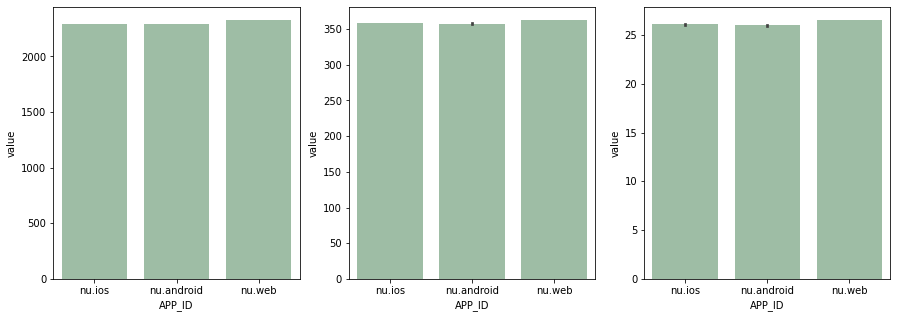

In [14]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments
fig, axes= plt.subplots(1, 3, figsize=(15, 5))
with_outliers = True
ax0 = sns.barplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_chars"], color='#99c2a2', ax=axes[0])
ax1 = sns.barplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_words"], color='#99c2a2', ax=axes[1])
ax2 = sns.barplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_sentences"], color='#99c2a2', ax=axes[2])
# for ax in [ax0,ax1,ax2]:
#     ax.set_xlim()

plt.show()



In [15]:
ddf3 = ddf_views[[ "APP_ID", "hour"]].compute()
ddf3.head()

APP_ID  hour
article_id                  
6               nu.web    10
17          nu.android    16
17          nu.android    13
17              nu.ios    13
1092            nu.web    20

# Correlation device and time of day
A graph has been created showing at what time of day interactions took place per device type. The samples taken from each category are equal, since in the dataset nu.web occurs more frequently than nu.ios and nu.android.

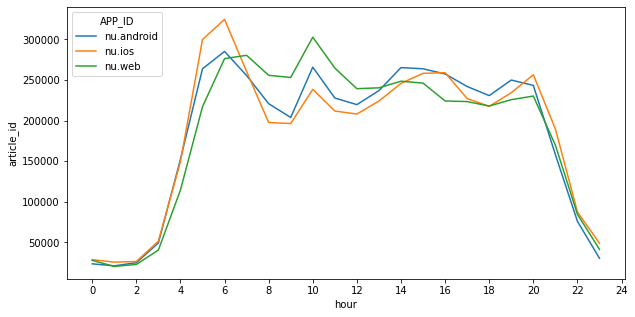

In [16]:
# TODO: Add a normalized graph
stepsize = 2
fig = plt.figure(figsize=(10, 5))
ax = sns.lineplot(x="hour", y="article_id", hue="APP_ID" ,data=ddf3.reset_index().groupby(["APP_ID", "hour"]).agg("count"))
ax.xaxis.set_ticks(np.arange(0, 26, stepsize))
plt.show()

In [17]:
from scipy.stats import entropy

ddf_topics = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_fixed_set_topics.csv', dtype={'sub_section': 'object',
       'url': 'object'},)
topic_columns = ddf_topics.columns[ddf_topics.columns.str.startswith("topic_")].values

ddf_topics = ddf_topics.reset_index().set_index('index')
ddf_topics = ddf_topics.assign(article_topic_entropy = dd.from_array(entropy(ddf_topics[topic_columns], axis=1)))
ddf_topics = ddf_topics.assign(argmax_topic = dd.from_array(ddf_topics[topic_columns].idxmax(axis=1).compute().values))
ddf_topics = ddf_topics.set_index('article_id')

ddf_topics.head()

topic_voetbal  topic_optredens_en_voorstellingen  topic_politiek  \
article_id                                                                     
537071           0.001038                           0.000917        0.015824   
962788           0.001125                           0.044565        0.000851   
1013291          0.105175                           0.028085        0.001613   
1149251          0.096021                           0.001019        0.000872   
1401797          0.002146                           0.001896        0.001623   

            topic_technologie_en_handel  topic_relatie_en_opvoeden  \
article_id                                                           
537071                         0.036879                   0.018781   
962788                         0.043789                   0.002104   
1013291                        0.025450                   0.024846   
1149251                        0.021542                   0.002109   
1401797                        0.002359                   0.004391   

            topic_bestuur_en_organisatie  topic_human_interest  \
article_id                                                       
537071                          0.000950              0.001434   
962788                          0.001030              0.001554   
1013291                         0.001953              0.036237   
1149251                         0.001056              0.011584   
1401797                         0.001965              0.002967   

            topic_verkeersongevallen  topic_nominatie_en_prijzen  \
article_id                                                         
537071                      0.027416                    0.000666   
962788                      0.161610                    0.000722   
1013291                     0.063389                    0.041297   
1149251                     0.148419                    0.000740   
1401797                     0.001080                    0.022382   

            topic_veiligheid  ...  topic_overheidsbeleid  \
article_id                    ...                          
537071              0.000616  ...               0.022336   
962788              0.000667  ...               0.001130   
1013291             0.001265  ...               0.024950   
1149251             0.000684  ...               0.001159   
1401797             0.001273  ...               0.002157   

            topic_vakbond_club_en_vereniging  topic_religie  \
article_id                                                    
537071                              0.028335       0.000673   
962788                              0.009267       0.000730   
1013291                             0.049110       0.001384   
1149251                             0.014120       0.000748   
1401797                             0.019468       0.001393   

            topic_bouwen_en_wonen  topic_recht_en_justitie  topic_samenleving  \
article_id                                                                      
537071                   0.000609                 0.000758           0.000555   
962788                   0.019392                 0.000822           0.000602   
1013291                  0.001251                 0.001558           0.001142   
1149251                  0.000677                 0.000842           0.000617   
1401797                  0.001259                 0.001567           0.001149   

            topic_woon_en_leefomgeving  file_name  article_topic_entropy  \
article_id                                                                 
537071                        0.036832          3               2.336185   
962788                        0.001987          1               2.428295   
1013291                       0.054470          2               2.660889   
1149251                       0.039665          3               2.116882   
1401797                       0.003774          3               2.471787   

                      argmax_topic  
article_id         

In [18]:
ddf_topics_merged = ddf_topics.merge(ddf_views[["APP_ID"]], how='inner', left_index=True, right_index=True)
# ddf_topics_merged = ddf_topics_merged.reset_index().set_index('index')
# ddf_topics_merged = ddf_topics_merged.assign(argmax_topic = pd.from_array(ddf_topics_merged[topic_columns].idxmax(axis=1).compute().values))
# ddf_topics_merged = ddf_topics_merged.reset_index(drop=True).reset_index()
display(ddf_topics_merged.head())


/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/core.py:7201: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


Empty DataFrame
Columns: [topic_voetbal, topic_optredens_en_voorstellingen, topic_politiek, topic_technologie_en_handel, topic_relatie_en_opvoeden, topic_bestuur_en_organisatie, topic_human_interest, topic_verkeersongevallen, topic_nominatie_en_prijzen, topic_veiligheid, topic_onderwijs, topic_maatschappelijke_instellingen, topic_economie, topic_lokale_evenementen, topic_het_weer, topic_brand, topic_verkeer, topic_gezondheid_en_zorg, topic_gemeentepolitiek, topic_sport, topic_kunst_en_cultuur, topic_eten_en_drinken, topic_natuur, topic_duurzaamheid, topic_misdaad, topic_wielrennen, topic_zingeving_en_verhalen, topic_afval_en_milieuproblematiek, topic_consumeren_en_vrije_tijd, topic_overheidsbeleid, topic_vakbond_club_en_vereniging, topic_religie, topic_bouwen_en_wonen, topic_recht_en_justitie, topic_samenleving, topic_woon_en_leefomgeving, file_name, article_topic_entropy, argmax_topic, APP_ID]
Index: []

[0 rows x 40 columns]

# Correlation device and topic
For a correlation between device type and topic, only the most prominent topic from the articles has been considered. Kruskal Wallis H reveals a signficant relation between the topics and device type.

3it [00:33, 11.09s/it]


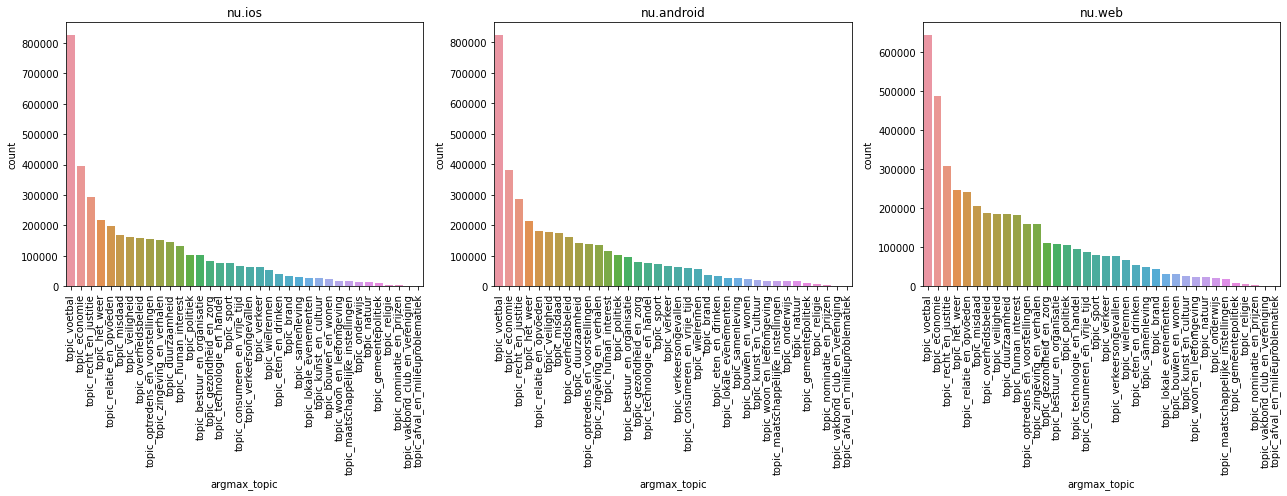

In [19]:
fig, axes = plt.subplots(1,3, figsize=(18, 7))
faxes = axes.flatten()
tmp = ddf_topics_merged[["argmax_topic", "APP_ID"]].compute()
for device, ax in tqdm.tqdm(zip(unique_devices, faxes)):
    order = tmp.loc[tmp["APP_ID"]==device]["argmax_topic"].value_counts().index
    ax = sns.countplot(data=tmp.loc[tmp["APP_ID"]==device], x="argmax_topic", ax=ax, order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(device)
fig.tight_layout()
plt.show()

In [20]:

l_test_results = list()
tmp = ddf_topics_merged.sample(frac=1).compute()
for topic in tqdm.tqdm(topic_columns):
    res = {"topic": topic, **pg.kruskal(data=tmp, dv=topic, between="APP_ID").iloc[0].to_dict()}
    l_test_results.append(res)
df_test_results = pd.DataFrame(l_test_results).sort_values("p-unc")
df_test_results

100%|██████████| 36/36 [07:55<00:00, 13.20s/it]


topic  Source  ddof1             H  \
0                         topic_voetbal  APP_ID      2  50231.905905   
32                topic_bouwen_en_wonen  APP_ID      2  11491.487711   
31                        topic_religie  APP_ID      2   2449.421687   
30     topic_vakbond_club_en_vereniging  APP_ID      2   2408.820077   
29                topic_overheidsbeleid  APP_ID      2   9062.027753   
28       topic_consumeren_en_vrije_tijd  APP_ID      2  24418.184997   
27    topic_afval_en_milieuproblematiek  APP_ID      2   2245.594237   
26          topic_zingeving_en_verhalen  APP_ID      2   1481.985841   
24                        topic_misdaad  APP_ID      2   5032.641203   
23                   topic_duurzaamheid  APP_ID      2  23733.004799   
22                         topic_natuur  APP_ID      2  16626.244247   
21                topic_eten_en_drinken  APP_ID      2   4380.498158   
20               topic_kunst_en_cultuur  APP_ID      2   2979.720861   
19                          topic_sport  APP_ID      2  20537.671262   
18               topic_gemeentepolitiek  APP_ID      2   6187.259227   
34                    topic_samenleving  APP_ID      2  13367.941484   
17             topic_gezondheid_en_zorg  APP_ID      2  21601.128308   
15                          topic_brand  APP_ID      2   4711.475892   
1     topic_optredens_en_voorstellingen  APP_ID      2   2276.662147   
2                        topic_politiek  APP_ID      2   2325.556608   
3           topic_technologie_en_handel  APP_ID      2   4396.315524   
4             topic_relatie_en_opvoeden  APP_ID      2   8882.567925   
6                  topic_human_interest  APP_ID      2  13139.612257   
16                        topic_verkeer  APP_ID      2   3066.706580   
35           topic_woon_en_leefomgeving  APP_ID      2  12497.035516   
9                      topic_veiligheid  APP_ID      2   4618.706000   
10                      topic_onderwijs  APP_ID      2   2558.607842   
11  topic_maatschappelijke_instellingen  APP_ID      2   5156.766044   
12                       topic_economie  APP_ID      2  19355.591298   
13             topic_lokale_evenementen  APP_ID      2   1996.893738   
14                       topic_het_weer  APP_ID      2   3366.435655   
7              topic_verkeersongevallen  APP_ID      2    375.299527   
25                     topic_wielrennen  APP_ID      2    362.902162   
8            topic_nominatie_en_prijzen  APP_ID      2    330.470505   
33              topic_recht_en_justitie  APP_ID      2    310.766833   
5          topic_bestuur_en_organisatie  APP_ID      2    267.591764   

           p-unc  
0   0.000000e+00  
32  0.000000e+00  
31  0.000000e+00  
30  0.000000e+00  
29  0.000000e+00  
28  0.000000e+00  
27  0.000000e+00  
26  0.000000e+00  
24  0.000000e+00  
23  0.000000e+00  
22  0.000000e+00  
21  0.000000e+00  
20  0.000000e+00  
19  0.000000e+00  
18  0.000000e+00  
34  0.000000e+00  
17  0.000000e+00  
15  0.000000e+00  
1   0.000000e+00  
2   0.000000e+00  
3   0.000000e+00  
4   0.000000e+00  
6   0.000000e+00  
16  0.000000e+00  
35  0.000000e+00  
9   0.000000e+00  
10  0.000000e+00  
11  0.000000e+00  
12  0.000000e+00  
13  0.000000e+00  
14  0.000000e+00  
7   3.197004e-82  
25  1.573246e-79  
8   1.734769e-72  
33  3.294881e-68  
5   7.819641e-59

100%|██████████| 36/36 [00:05<00:00,  6.25it/s]


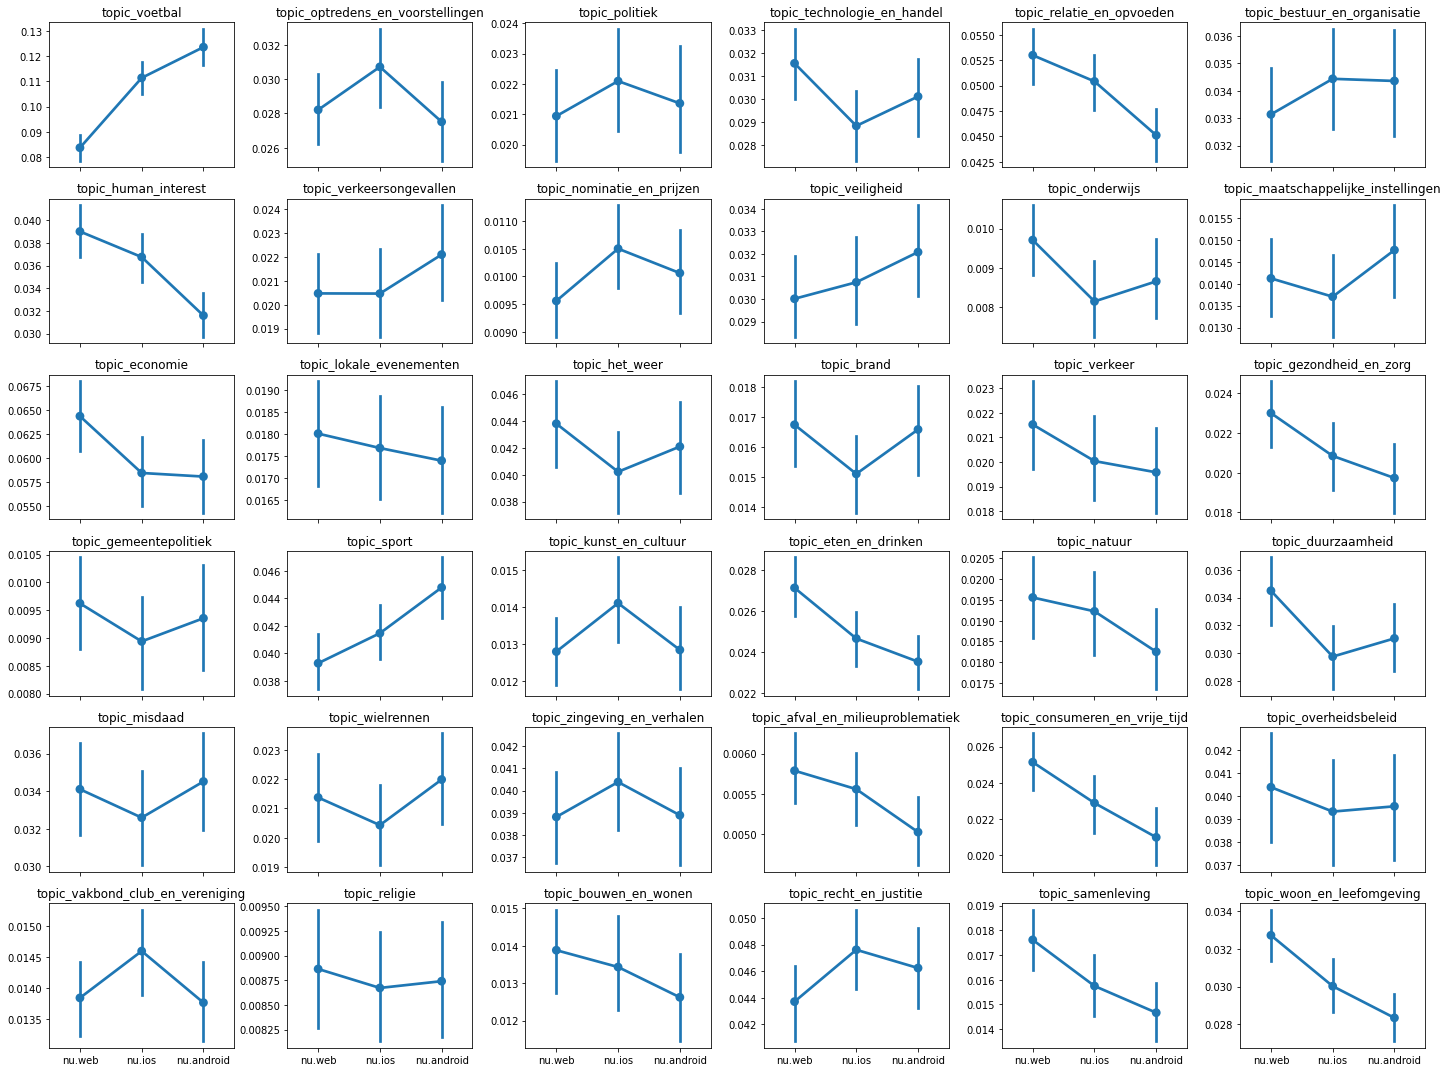

In [21]:
# TODO: Correct the yscales
fig, axes = plt.subplots(6,6,figsize=(20, 15), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_topics_merged.sample(frac=0.001).compute()
for topic, ax in tqdm.tqdm(zip(topic_columns, faxes), total=len(topic_columns)):
    ax = sns.pointplot(data=tmp, x="APP_ID", y=topic, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(topic)
fig.tight_layout()  
plt.show()

# Correlation device and topic diversity
Topic diversity has been measured in terms of article entropy. The means of the entropies of articles across device types has been compared. Since it looks like a normal distribution, ANOVA has been applied. It results in a signficant p-value, but a low np2 means a small effect size.
There are no discernible clusters in a 2-dimensional space.


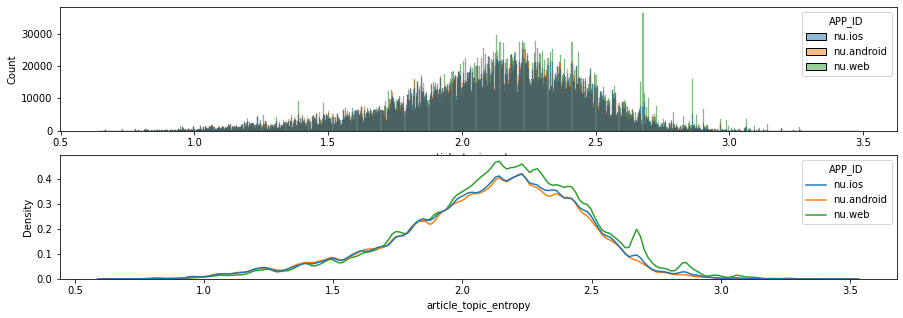

In [22]:
fig, axes = plt.subplots(2,1,figsize=(15, 5))
tmp = ddf_topics_merged.sample(frac=1).compute().reset_index()
sns.histplot(data=tmp, x="article_topic_entropy", hue="APP_ID", ax=axes[0])
sns.kdeplot(data=tmp, x="article_topic_entropy", hue="APP_ID", ax=axes[1])
plt.show()

In [23]:
# median_fun = pd.Aggregation(
#     name="median",
#     # this computes the median on each partition
#     chunk=lambda s: s.median(),
#     # this combines results across partitions; the input should just be a list of length 1
#     agg=lambda s0: s0.sum(),
# )
ddf_topics_merged[["APP_ID", "article_topic_entropy"]].groupby("APP_ID").agg(["mean", "std", "min", "max"]).compute()

article_topic_entropy                              
                            mean       std       min       max
APP_ID                                                        
nu.android              2.093438  0.352107  0.638017  3.482929
nu.ios                  2.103403  0.353090  0.638017  3.482929
nu.web                  2.144522  0.350889  0.638017  3.482929

In [24]:
tmp = ddf_topics_merged.compute()
pg.anova(data=tmp, dv='article_topic_entropy', between='APP_ID')

Source  ddof1     ddof2             F  p-unc       np2
0  APP_ID      2  12184190  24779.786451    0.0  0.004051

<AxesSubplot:xlabel='APP_ID', ylabel='article_topic_entropy'>

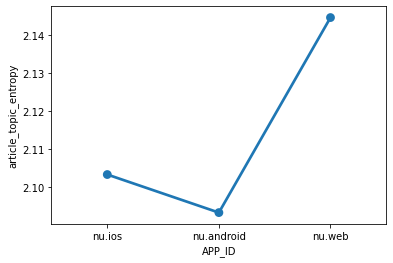

In [25]:
fig, ax = plt.subplots(1,1)
sns.pointplot(data=tmp, x="APP_ID", y='article_topic_entropy', ax=ax)

In [26]:
centroids = ddf_topics_merged[["APP_ID"]+list(topic_columns)].groupby("APP_ID").agg(np.mean).compute()
centroids

topic_voetbal  topic_optredens_en_voorstellingen  topic_politiek  \
APP_ID                                                                         
nu.android       0.118234                           0.028060        0.021346   
nu.ios           0.115125                           0.029795        0.021650   
nu.web           0.082488                           0.027976        0.021267   

            topic_technologie_en_handel  topic_relatie_en_opvoeden  \
APP_ID                                                               
nu.android                     0.029920                   0.046344   
nu.ios                         0.029838                   0.049206   
nu.web                         0.031650                   0.051412   

            topic_bestuur_en_organisatie  topic_human_interest  \
APP_ID                                                           
nu.android                      0.033896              0.033948   
nu.ios                          0.033996              0.035914   
nu.web                          0.032740              0.039730   

            topic_verkeersongevallen  topic_nominatie_en_prijzen  \
APP_ID                                                             
nu.android                  0.021353                    0.010074   
nu.ios                      0.020815                    0.010332   
nu.web                      0.020227                    0.010017   

            topic_veiligheid  ...  topic_zingeving_en_verhalen  \
APP_ID                        ...                                
nu.android          0.032246  ...                     0.038743   
nu.ios              0.030509  ...                     0.040501   
nu.web              0.031775  ...                     0.039749   

            topic_afval_en_milieuproblematiek  topic_consumeren_en_vrije_tijd  \
APP_ID                                                                          
nu.android                           0.005503                        0.021693   
nu.ios                               0.005622                        0.022417   
nu.web                               0.005670                        0.025623   

            topic_overheidsbeleid  topic_vakbond_club_en_vereniging  \
APP_ID                                                                
nu.android               0.038629                          0.014647   
nu.ios                   0.038211                          0.014347   
nu.web                   0.039878                          0.013692   

            topic_religie  topic_bouwen_en_wonen  topic_recht_en_justitie  \
APP_ID                                                                      
nu.android       0.009393               0.013105                 0.047424   
nu.ios           0.009088               0.013088                 0.047180   
nu.web           0.008603               0.014308                 0.046262   

            topic_samenleving  topic_woon_en_leefomgeving  
APP_ID                                                     
nu.android           0.014154                    0.029228  
nu.ios               0.014670                    0.029637  
nu.web               0.017302                    0.032109  

[3 rows x 36 columns]

In [27]:
# https://github.com/silviatti/topic-model-diversity
X = centroids.values
pd.DataFrame(cdist(X,X, "euclidean"), index=centroids.index, columns=centroids.index)

APP_ID      nu.android    nu.ios    nu.web
APP_ID                                    
nu.android    0.000000  0.006597  0.039197
nu.ios        0.006597  0.000000  0.035453
nu.web        0.039197  0.035453  0.000000

In [28]:
# https://github.com/silviatti/topic-model-diversity
X = centroids.values
pd.DataFrame(cdist(X,X, "cosine"), index=centroids.index, columns=centroids.index)

APP_ID        nu.android    nu.ios    nu.web
APP_ID                                      
nu.android  1.110223e-16  0.000512  0.017753
nu.ios      5.124122e-04  0.000000  0.014531
nu.web      1.775275e-02  0.014531  0.000000

<AxesSubplot:>

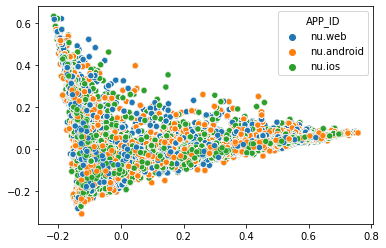

In [29]:
from sklearn.decomposition import PCA
reducer = PCA(2)
data = ddf_topics_merged.sample(frac=1).dropna().compute()
reduced_data = reducer.fit_transform(data[list(topic_columns)])
sns.scatterplot(x = reduced_data[:, 0], y = reduced_data[:, 1], hue=data["APP_ID"])

# Correlation device and USERNEEDS
Kruskal Wallis H reveals a signficant p-value for all the different userneeds across device types

In [30]:
ddf_userneeds = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_fixed_set_userneeds.csv', dtype={'sub_section': 'object',
       'url': 'object'},)
columns_userneeds = ddf_userneeds.columns[ddf_userneeds.columns.str.startswith("userneed_")].values
ddf_userneeds = ddf_userneeds.assign(argmax_userneeds = ddf_userneeds[columns_userneeds].idxmax(axis=1))
ddf_userneeds = ddf_userneeds.set_index('article_id')
ddf_userneeds.head()

userneed_hou_me_op_de_hoogte  userneed_geef_me_context  \
article_id                                                           
537071                          0.282037                  0.224568   
962788                          0.121325                  0.065335   
1013291                         0.132751                  0.059254   
1149251                         0.159672                  0.108233   
1401797                         0.071099                  0.054092   

            userneed_vermaak_me  userneed_raak_me_verbind_me  \
article_id                                                     
537071                 0.279466                     0.030468   
962788                 0.212335                     0.015897   
1013291                0.704135                     0.089935   
1149251                0.444364                     0.015201   
1401797                0.790514                     0.059013   

            userneed_help_me  file_name              argmax_userneeds  
article_id                                                             
537071              0.183461          3  userneed_hou_me_op_de_hoogte  
962788              0.585109          1              userneed_help_me  
1013291             0.013925          2           userneed_vermaak_me  
1149251             0.272529          3           userneed_vermaak_me  
1401797             0.025282          3           userneed_vermaak_me

In [31]:
ddf_userneeds_merged = ddf_userneeds.merge(ddf_views[["APP_ID"]], how="inner", left_index=True, right_index=True)
ddf_userneeds_merged.head()

/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/core.py:7201: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


Empty DataFrame
Columns: [userneed_hou_me_op_de_hoogte, userneed_geef_me_context, userneed_vermaak_me, userneed_raak_me_verbind_me, userneed_help_me, file_name, argmax_userneeds, APP_ID]
Index: []

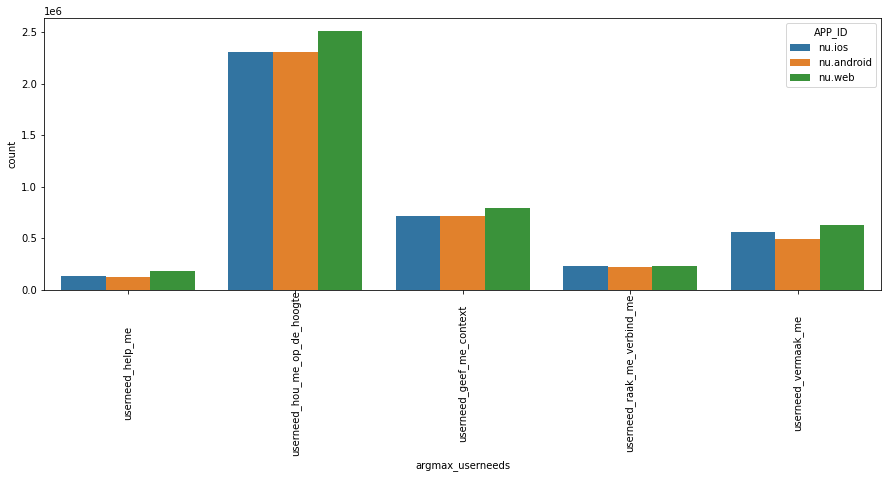

In [32]:
fig, axes = plt.subplots(1,1,figsize=(15, 5))
tmp = ddf_userneeds_merged[["argmax_userneeds", "APP_ID"]].compute()
ax = sns.countplot(data=tmp, x="argmax_userneeds", hue="APP_ID", ax=axes)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, va="center", position=(0,-0.28))
plt.show()

In [33]:
l_test_results = list()
tmp = ddf_userneeds_merged.sample(frac=0.1).compute()
for need in tqdm.tqdm(columns_userneeds):
    res = {"need": need, **pg.kruskal(data=tmp, dv=need, between="APP_ID").iloc[0].to_dict()}
    l_test_results.append(res)
df_test_results = pd.DataFrame(l_test_results).sort_values("p-unc")
df_test_results

100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


need  Source  ddof1            H          p-unc
4              userneed_help_me  APP_ID      2  1643.372695   0.000000e+00
2           userneed_vermaak_me  APP_ID      2   815.862288  6.882640e-178
0  userneed_hou_me_op_de_hoogte  APP_ID      2   737.736755  6.345985e-161
3   userneed_raak_me_verbind_me  APP_ID      2   387.455148   7.331343e-85
1      userneed_geef_me_context  APP_ID      2     2.321953   3.131803e-01

100%|██████████| 5/5 [00:54<00:00, 10.94s/it]


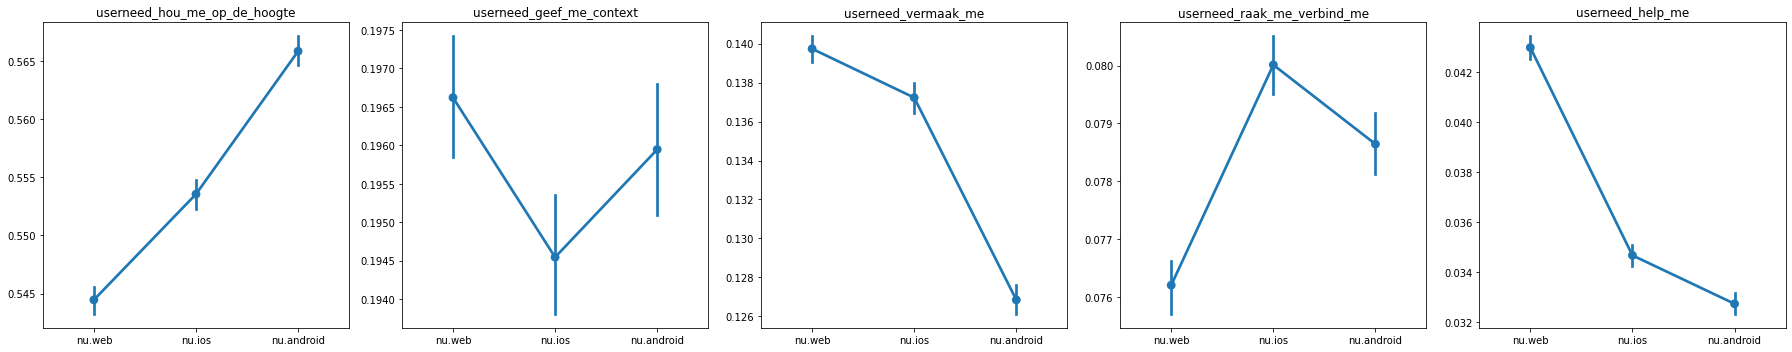

In [34]:
fig, axes = plt.subplots(1, len(columns_userneeds),figsize=(25, 5), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_userneeds_merged.sample(frac=0.1).compute()
for need, ax in tqdm.tqdm(zip(columns_userneeds, faxes), total=len(columns_userneeds)):
    ax = sns.pointplot(data=tmp, x="APP_ID", y=need, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(need)
fig.tight_layout()  
plt.show()

# LOCATION

In [41]:
import pgeocode as geo

In [5]:
nomi = geo.Nominatim('nl')


In [6]:
# https://pypi.org/project/pgeocode/
# https://www.cbs.nl/en-gb/our-services/open-data/statline-as-open-data/cartography
ddf_location = ddf_views[["GEO_CITY","GEO_COUNTRY","GEO_REGION","GEO_ZIPCODE"]]
ddf_location.head()
display(ddf_location)

Dask DataFrame Structure:
               GEO_CITY GEO_COUNTRY GEO_REGION GEO_ZIPCODE
npartitions=33                                            
                  int64      object     object      object
                    ...         ...        ...         ...
...                 ...         ...        ...         ...
                    ...         ...        ...         ...
                    ...         ...        ...         ...
Dask Name: getitem, 825 tasks

Series([], Name: 0, dtype: object)

In [19]:
meta = {'postal_code': 'object', 'country_code': 'object', 'place_name': 'object', 'state_name': 'object', 'state_code': 'object', 'county_name': 'object', 'county_code': 'object', 'community_name': 'object', 'community_code': 'object', 'latitude': 'float64', 'longitude': 'float64', 'accuracy': 'float64'}
ddf_location["GEO_REGION"].apply(lambda x: nomi.query_postal_code(x), meta=dd.utils.make_meta(nomi.query_postal_code('3526'))).head() 

ValueError: DataFrame constructor not properly called!

# INTERACTION

In [38]:
DATA_FOLDER = "reduced"
ddf_interactions = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER}/reduced_interactions.csv', dtype={'sub_section': 'object',
       'url': 'object'},)
tmp = ddf_interactions[["ARTICLE_ID","SE_LABEL", "SE_ACTION"]].compute()
unique_interactions_1 = tmp["SE_LABEL"].unique()
unique_interactions_2 = tmp["SE_ACTION"].unique()
ddf_interactions.head()

APP_ID  ARTICLE_ID            DERIVED_TSTAMP      SE_ACTION SE_CATEGORY  \
0  nu.web     6192670  2022-04-01T07:16:48.806Z  post-reaction       nujij   
1  nu.web     6192592  2022-04-01T08:02:14.027Z  post-reaction       nujij   
2  nu.web     6192670  2022-04-01T08:01:27.569Z  post-reaction       nujij   
3  nu.web     6192670  2022-04-01T08:02:12.540Z  post-reaction       nujij   
4  nu.web     6192629  2022-04-01T07:51:56.635Z  post-reaction       nujij   

              SE_LABEL  SE_VALUE                     QUASI_USER_ID  \
0  comment-on-reaction       1.0  780840469334879923dbe38c0e8a2ab3   
1         new-reaction       1.0  5132ce5b0ccb5b3a2f9b2775a99d2ee7   
2  comment-on-reaction       1.0  e9dcaa5ab5e431e1f86a018e92008043   
3         new-reaction       1.0  9fdbeac954e9c98ab8323f6fc2520910   
4  comment-on-reaction       1.0  fc39be4398815482fe41575af63f6587   

   IS_LOGGED_IN  GEO_CITY  ...  privacy_non-personalised_ads  \
0             1        24  ...                             1   
1             1        15  ...                             1   
2             1       303  ...                             1   
3             1        16  ...                             1   
4             1       615  ...                             1   

   privacy_marketing  privacy_social_media  privacy_geo_location  \
0                  1                     1                     0   
1                  1                     1                     0   
2                  1                     1                     0   
3                  1                     1                     0   
4                  1                     1                     0   

   privacy_advertising  file_name  GEO_COUNTRY  GEO_REGION  GEO_ZIPCODE  \
0                    1          0          NaN         NaN          NaN   
1                    1          0           NL          ZH         3079   
2                    1          0           NL          FL         3893   
3                    1          0           NL          ZH         2513   
4                    1          0           BE         VAN         2280   

   REFR_MEDIUM  
0          NaN  
1          NaN  
2     internal  
3          NaN  
4          NaN  

[5 rows x 25 columns]

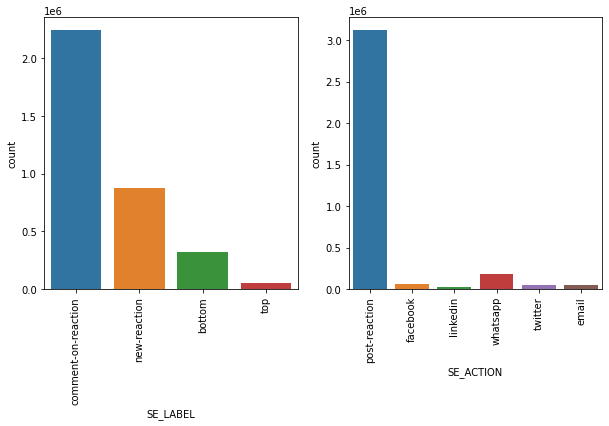

In [39]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(data=tmp, x="SE_LABEL", ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 90)
sns.countplot(data=tmp, x="SE_ACTION", ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 90)
plt.show()


In [40]:
ddf_topics_merged_interactions = ddf_topics.merge(ddf_interactions[["ARTICLE_ID", "SE_LABEL", "SE_ACTION"]], how="inner", left_on='article_id', right_on='ARTICLE_ID')
display(ddf_topics_merged.head())


/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/core.py:7201: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


Empty DataFrame
Columns: [topic_voetbal, topic_optredens_en_voorstellingen, topic_politiek, topic_technologie_en_handel, topic_relatie_en_opvoeden, topic_bestuur_en_organisatie, topic_human_interest, topic_verkeersongevallen, topic_nominatie_en_prijzen, topic_veiligheid, topic_onderwijs, topic_maatschappelijke_instellingen, topic_economie, topic_lokale_evenementen, topic_het_weer, topic_brand, topic_verkeer, topic_gezondheid_en_zorg, topic_gemeentepolitiek, topic_sport, topic_kunst_en_cultuur, topic_eten_en_drinken, topic_natuur, topic_duurzaamheid, topic_misdaad, topic_wielrennen, topic_zingeving_en_verhalen, topic_afval_en_milieuproblematiek, topic_consumeren_en_vrije_tijd, topic_overheidsbeleid, topic_vakbond_club_en_vereniging, topic_religie, topic_bouwen_en_wonen, topic_recht_en_justitie, topic_samenleving, topic_woon_en_leefomgeving, file_name, article_topic_entropy, argmax_topic, APP_ID]
Index: []

[0 rows x 40 columns]

4it [00:03,  1.15it/s]


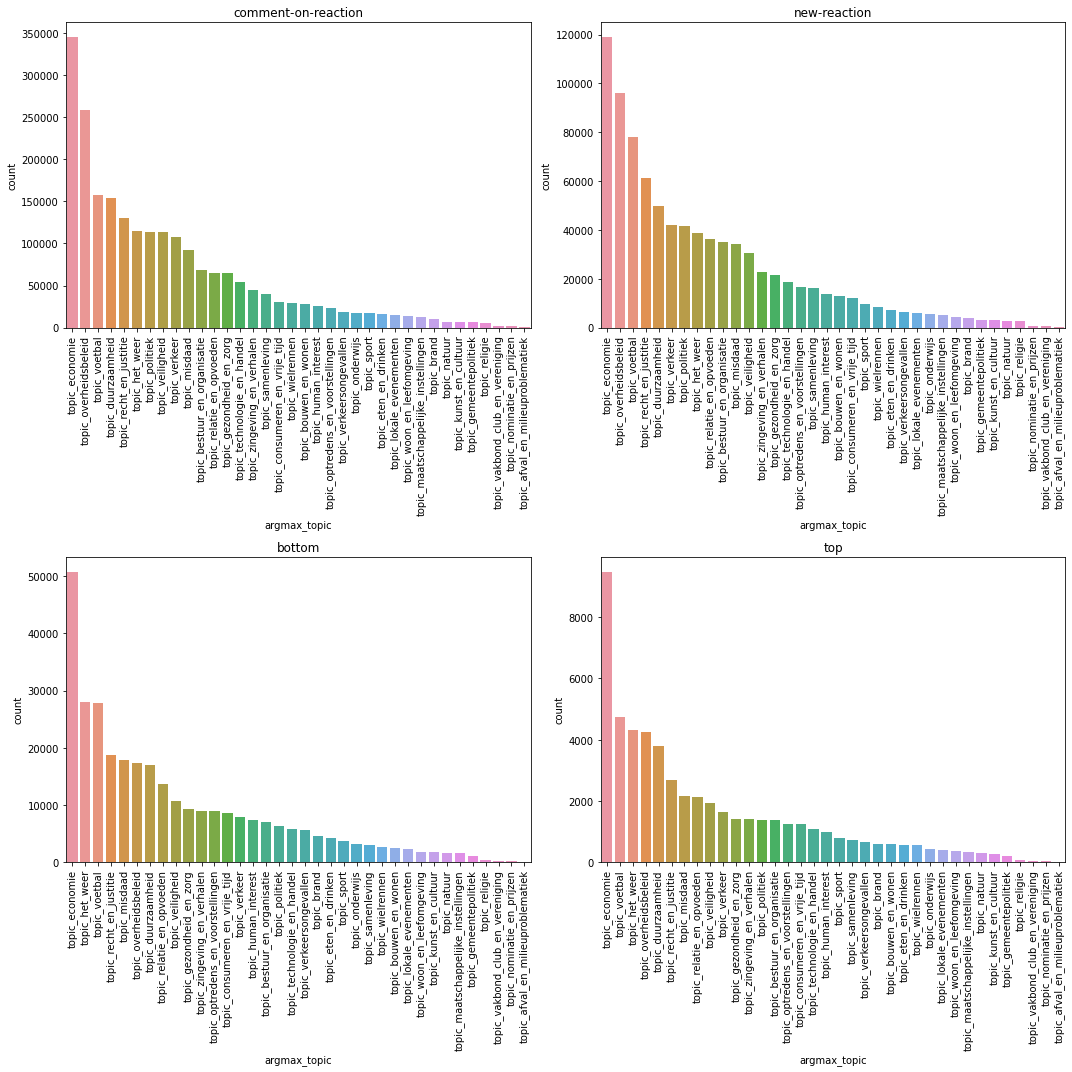

In [41]:
fig, axes = plt.subplots(2,(len(unique_interactions_1)//2), figsize=(15, 15))
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions[["argmax_topic", "SE_LABEL"]].compute()
for interaction, ax in tqdm.tqdm(zip(unique_interactions_1, faxes)):
    order = tmp.loc[tmp["SE_LABEL"]==interaction]["argmax_topic"].value_counts().index
    ax = sns.countplot(data=tmp.loc[tmp["SE_LABEL"]==interaction], x="argmax_topic", ax=ax, order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(interaction)
fig.tight_layout()
plt.show()

6it [00:04,  1.36it/s]


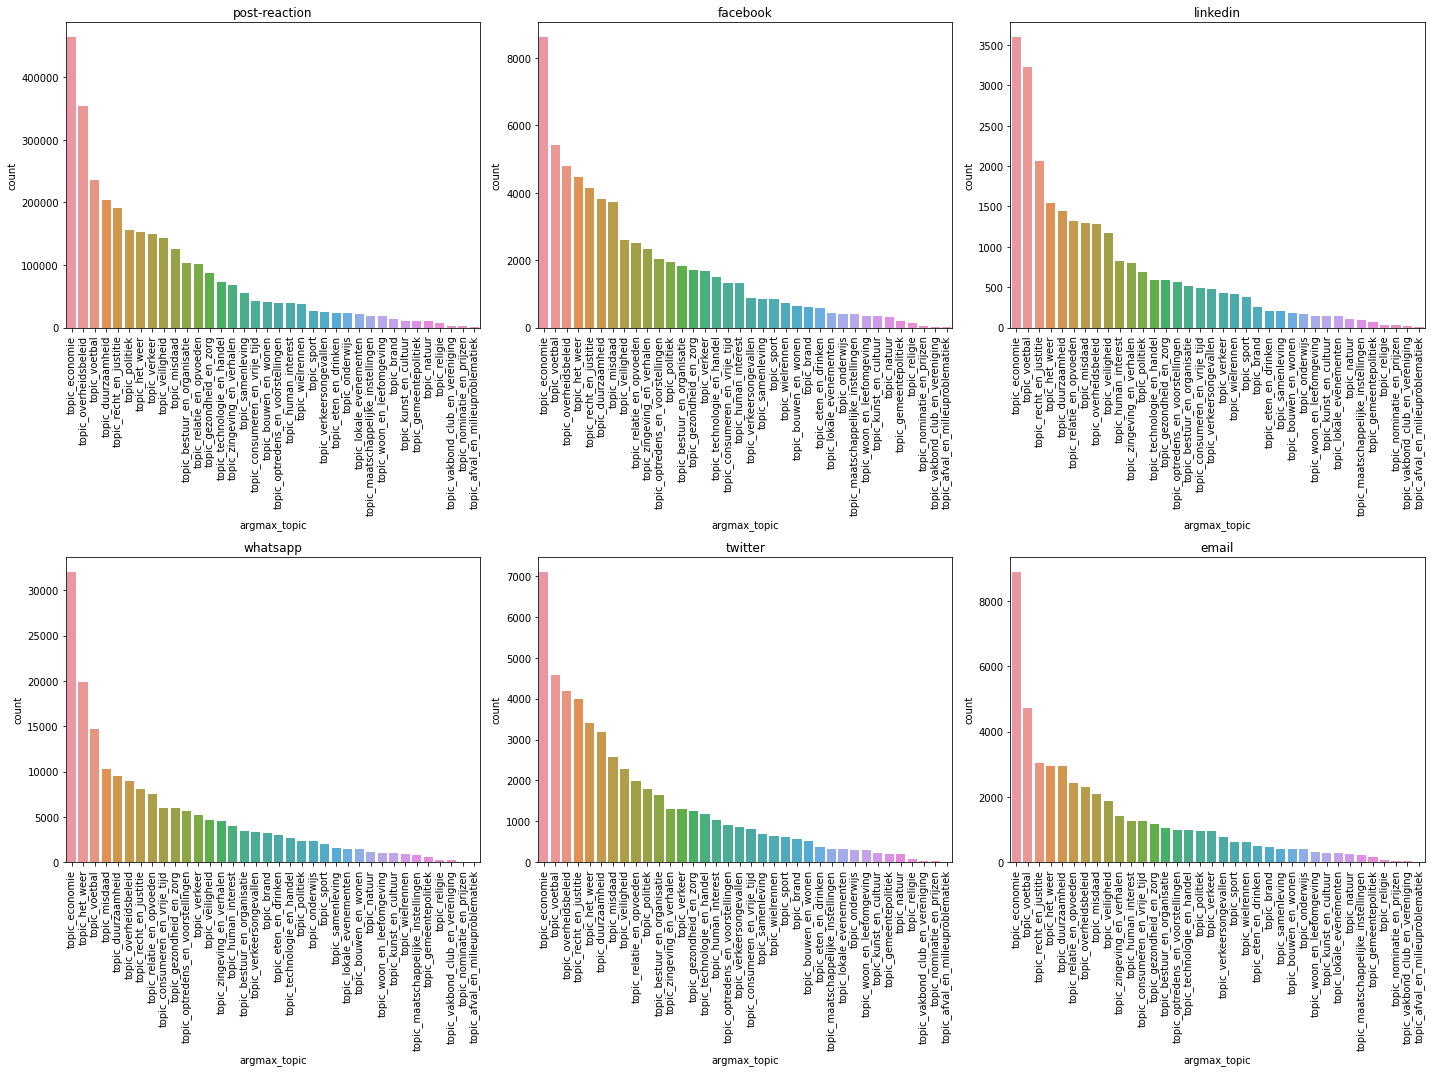

In [42]:
fig, axes = plt.subplots(2,(len(unique_interactions_2)//2), figsize=(20, 15))
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions[["argmax_topic", "SE_ACTION"]].compute()
for interaction, ax in tqdm.tqdm(zip(unique_interactions_2, faxes)):
    order = tmp.loc[tmp["SE_ACTION"]==interaction]["argmax_topic"].value_counts().index
    ax = sns.countplot(data=tmp.loc[tmp["SE_ACTION"]==interaction], x="argmax_topic", ax=ax, order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(interaction)
fig.tight_layout()
plt.show()

In [43]:
l_test_results = list()
tmp = ddf_topics_merged_interactions.sample(frac=0.01).compute()
for topic in tqdm.tqdm(topic_columns):
    res = {"topic": topic, **pg.kruskal(data=tmp, dv=topic, between="SE_LABEL").iloc[0].to_dict()}
    l_test_results.append(res)
df_test_results = pd.DataFrame(l_test_results).sort_values("p-unc")
df_test_results

100%|██████████| 36/36 [00:00<00:00, 65.75it/s]


topic    Source  ddof1           H  \
29                topic_overheidsbeleid  SE_LABEL      3  240.657766   
6                  topic_human_interest  SE_LABEL      3  147.339482   
7              topic_verkeersongevallen  SE_LABEL      3  110.376908   
17             topic_gezondheid_en_zorg  SE_LABEL      3  107.024381   
20               topic_kunst_en_cultuur  SE_LABEL      3   98.728125   
2                        topic_politiek  SE_LABEL      3   97.597878   
0                         topic_voetbal  SE_LABEL      3   91.248555   
14                       topic_het_weer  SE_LABEL      3   79.432707   
23                   topic_duurzaamheid  SE_LABEL      3   78.678388   
1     topic_optredens_en_voorstellingen  SE_LABEL      3   74.606139   
28       topic_consumeren_en_vrije_tijd  SE_LABEL      3   73.306305   
4             topic_relatie_en_opvoeden  SE_LABEL      3   68.751152   
26          topic_zingeving_en_verhalen  SE_LABEL      3   63.870516   
21                topic_eten_en_drinken  SE_LABEL      3   59.764352   
22                         topic_natuur  SE_LABEL      3   54.917513   
35           topic_woon_en_leefomgeving  SE_LABEL      3   49.397377   
19                          topic_sport  SE_LABEL      3   48.996966   
12                       topic_economie  SE_LABEL      3   45.503046   
13             topic_lokale_evenementen  SE_LABEL      3   39.870525   
9                      topic_veiligheid  SE_LABEL      3   38.894634   
3           topic_technologie_en_handel  SE_LABEL      3   34.306563   
5          topic_bestuur_en_organisatie  SE_LABEL      3   32.693618   
8            topic_nominatie_en_prijzen  SE_LABEL      3   30.867479   
25                     topic_wielrennen  SE_LABEL      3   25.794463   
30     topic_vakbond_club_en_vereniging  SE_LABEL      3   23.239884   
27    topic_afval_en_milieuproblematiek  SE_LABEL      3   22.317877   
24                        topic_misdaad  SE_LABEL      3   21.386553   
33              topic_recht_en_justitie  SE_LABEL      3   20.962447   
32                topic_bouwen_en_wonen  SE_LABEL      3   20.851861   
31                        topic_religie  SE_LABEL      3   18.461673   
10                      topic_onderwijs  SE_LABEL      3   14.205593   
18               topic_gemeentepolitiek  SE_LABEL      3   10.739295   
34                    topic_samenleving  SE_LABEL      3    7.043703   
15                          topic_brand  SE_LABEL      3    6.194175   
16                        topic_verkeer  SE_LABEL      3    3.689078   
11  topic_maatschappelijke_instellingen  SE_LABEL      3    3.220550   

           p-unc  
29  6.859044e-52  
6   9.877699e-32  
7   9.103755e-24  
17  4.793303e-23  
20  2.917121e-21  
2   5.104272e-21  
0   1.181312e-19  
14  4.061761e-17  
23  5.895100e-17  
1   4.400667e-16  
28  8.357119e-16  
4   7.900262e-15  
26  8.748440e-14  
21  6.600694e-13  
22  7.150094e-12  
35  1.073562e-10  
19  1.306398e-10  
12  7.233480e-10  
13  1.135014e-08  
9   1.827201e-08  
3   1.706869e-07  
5   3.737357e-07  
8   9.064520e-07  
25  1.053073e-05  
30  3.599053e-05  
27  5.601377e-05  
24  8.750292e-05  
33  1.071837e-04  
32  1.130031e-04  
31  3.532079e-04  
10  2.638252e-03  
18  1.322246e-02  
34  7.051777e-02  
15  1.025360e-01  
16  2.970545e-01  
11  3.588545e-01

100%|██████████| 36/36 [00:12<00:00,  2.90it/s]


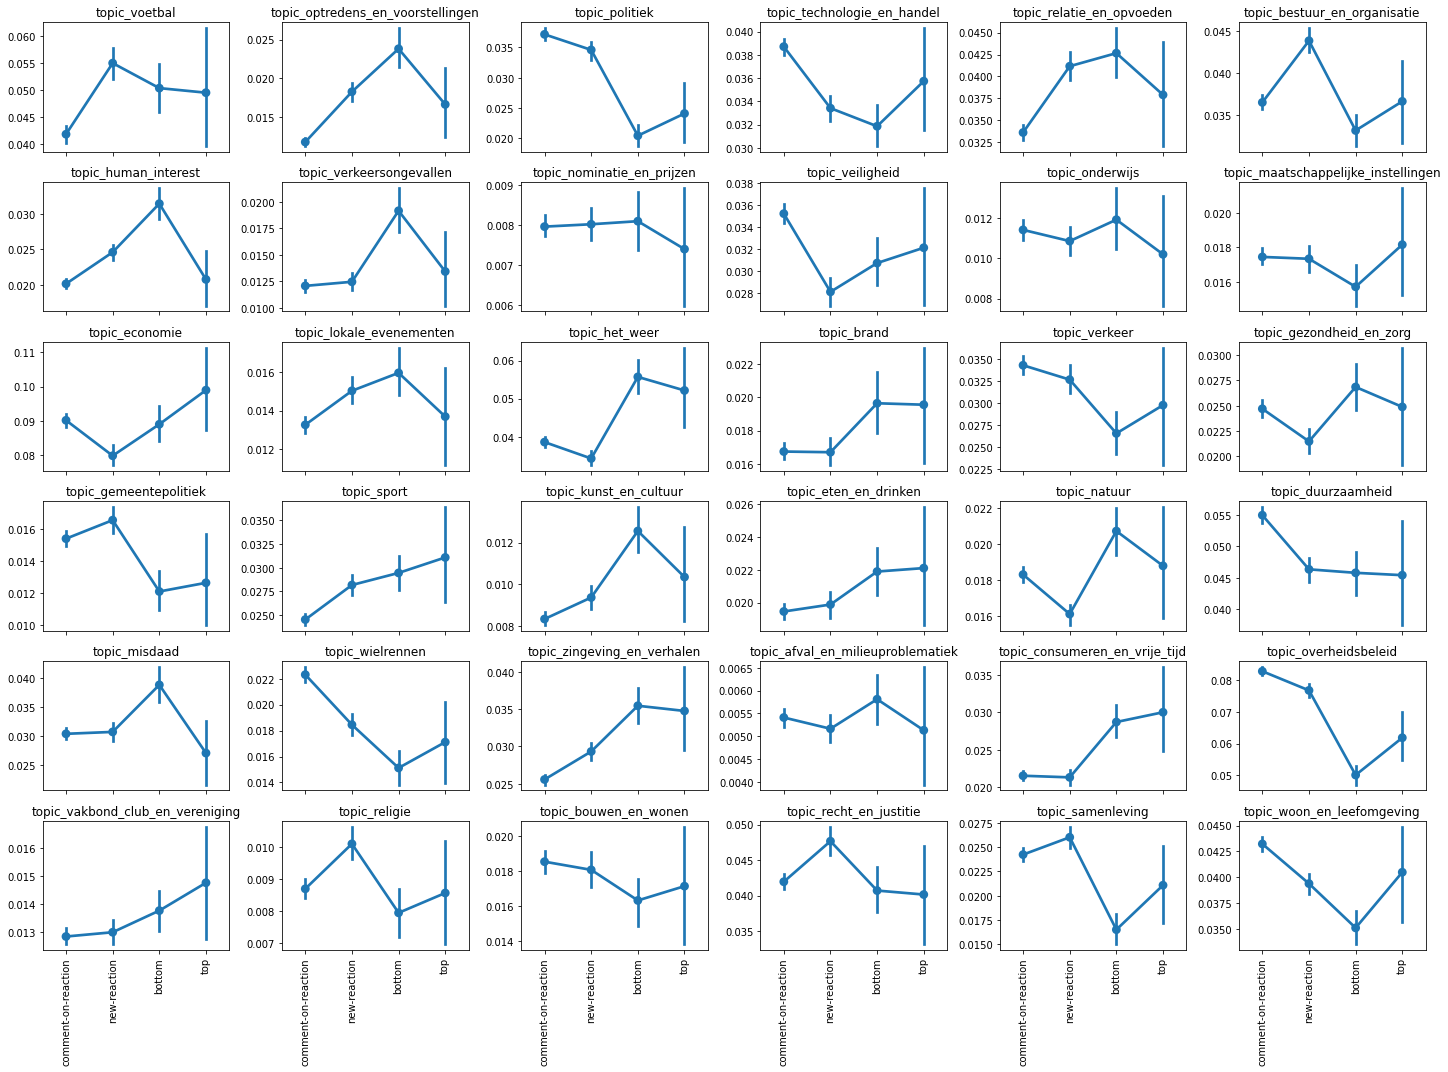

In [44]:
# TODO: Change the scale so it's not shared between the plots
fig, axes = plt.subplots(6,6,figsize=(20, 15), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions.sample(frac=0.01).compute()
for topic, ax in tqdm.tqdm(zip(topic_columns, faxes), total=len(topic_columns)):
    ax = sns.pointplot(data=tmp, x="SE_LABEL", y=topic, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(topic)
fig.tight_layout()  
plt.show()

100%|██████████| 36/36 [01:44<00:00,  2.89s/it]


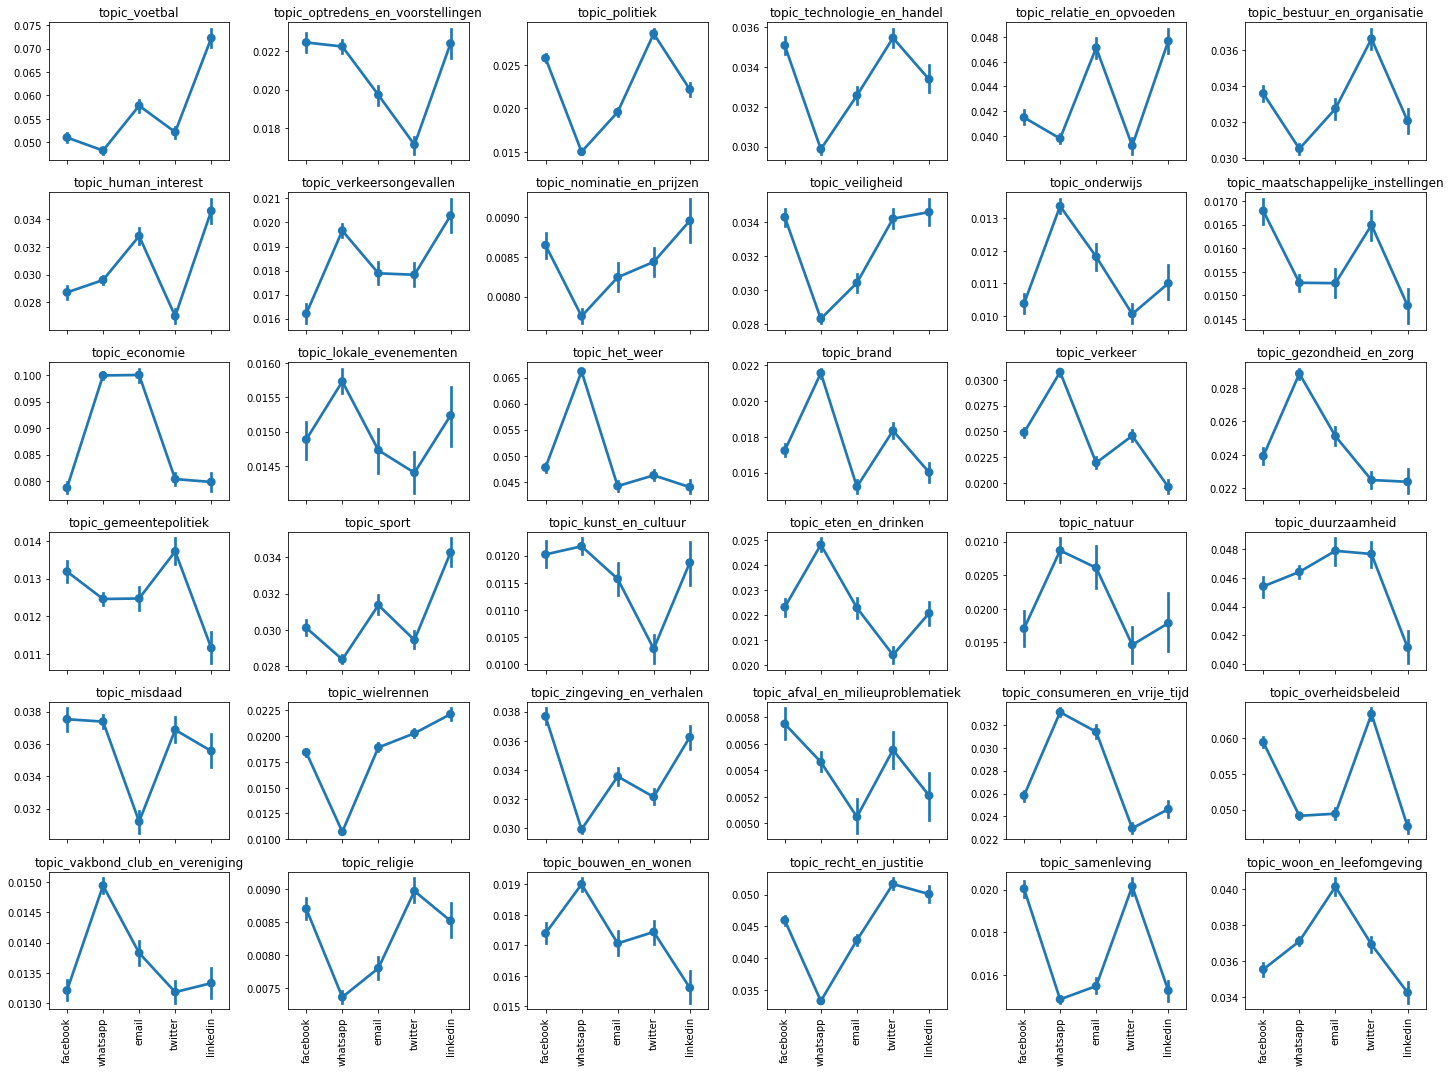

In [45]:
fig, axes = plt.subplots(6,6,figsize=(20, 15), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions[ddf_topics_merged_interactions["SE_ACTION"] != "post-reaction"].sample(frac=1).compute()
for topic, ax in tqdm.tqdm(zip(topic_columns, faxes), total=len(topic_columns)):
    ax = sns.pointplot(data=tmp, x="SE_ACTION", y=topic, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(topic)
fig.tight_layout()  
plt.show()